# Lead Scoring Case Study

An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses. 
 

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%.

Now, although X Education gets a lot of leads, its lead conversion rate is very poor. For example, if, say, they acquire 100 leads in a day, only about 30 of them are converted. To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’. If they successfully identify this set of leads, the lead conversion rate should go up as the sales team will now be focusing more on communicating with the potential leads rather than making calls to everyone.

The company requires to build a model wherein we need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

### Purpose

Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.

In [192]:
#Supressing warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing important packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn.metrics import precision_recall_curve

In [3]:
#Setting some options
pd.set_option("max_columns",None)
pd.set_option("max_rows",None)

In [4]:
#Reading the Dataset
df=pd.read_csv("Leads.csv")

# Dataset Inspection

In [5]:
df.shape

(9240, 37)

In [6]:
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


As we see that some columns have Select value which is as null values and hence we will replace these values

In [7]:
df=df.replace("Select",np.nan)

### Feature Engineering

#### We are creating a variable called Null_Count which calculates the number of missing values for each lead. We think it is important as to what amount of information the customer is giving with regards to the conversion rate. 

In [8]:
df["Null_Count"] = df.isnull().sum(axis = 1)

### Let's now inspect all the variables and see how many unique values these columns have

In [9]:
df.nunique(dropna = False)

Prospect ID                                      9240
Lead Number                                      9240
Lead Origin                                         5
Lead Source                                        22
Do Not Email                                        2
Do Not Call                                         2
Converted                                           2
TotalVisits                                        42
Total Time Spent on Website                      1731
Page Views Per Visit                              115
Last Activity                                      18
Country                                            39
Specialization                                     19
How did you hear about X Education                 10
What is your current occupation                     7
What matters most to you in choosing a course       4
Search                                              2
Magazine                                            1
Newspaper Article           

#### As the number of unique values for Prospect ID, Lead Number = 9240, i.e all values are unique and hence we'll drop these columns as they as of little use to us.
#### Also some columns have only one unique value and these columns would also be of least importance to our analysis and hence we'll delete these columns.

In [10]:
df.index = df["Lead Number"]

In [11]:
for i in df.columns:
    if (df[i].nunique()) == 1 or (df[i].nunique() == df.shape[0]):
        df.drop(i, axis = 1, inplace = True)

In [12]:
df.shape

(9240, 31)

### We'll now look for missing values in our data

In [13]:
null_percent = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
null_percent

How did you hear about X Education               78.463203
Lead Profile                                     74.188312
Lead Quality                                     51.590909
Asymmetrique Profile Score                       45.649351
Asymmetrique Activity Score                      45.649351
Asymmetrique Profile Index                       45.649351
Asymmetrique Activity Index                      45.649351
City                                             39.707792
Specialization                                   36.580087
Tags                                             36.287879
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
TotalVisits                                       1.482684
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Lead Source                                       0.3896

#### Looking at the columns, we take 40% to be the threshold for missing values and we'll drop all the columns that have more than 40% of missing values.

In [14]:
# Dropping the columns with more than 45% Null values.
for i in null_percent.index:
    if null_percent[i]>40:
        df.drop(i,axis=1,inplace=True)

In [15]:
df.shape

(9240, 24)

#### Now that we have removed all the unnecessary columns, we'll go ahead and look at the remaining columns individually, remove the missing values from them, explore them for EDA and make them ready for the regression. 

## Missing value treatment, Data Preprocessing and Exploratory data analysis

In [16]:
# Renaming the columns for our convinience.
df.columns = ['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization',
       'Current occupation', 'Reason_choose_course', 'Search',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags', 'City',
       'Mastering_Interview_Copy', 'Last Notable Activity', 'Null_Count']

In [17]:
 (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)

City                           39.707792
Specialization                 36.580087
Tags                           36.287879
Reason_choose_course           29.318182
Current occupation             29.112554
Country                        26.634199
TotalVisits                     1.482684
Page Views Per Visit            1.482684
Last Activity                   1.114719
Lead Source                     0.389610
Do Not Email                    0.000000
Do Not Call                     0.000000
Converted                       0.000000
Total Time Spent on Website     0.000000
Null_Count                      0.000000
Last Notable Activity           0.000000
Search                          0.000000
Newspaper Article               0.000000
X Education Forums              0.000000
Newspaper                       0.000000
Digital Advertisement           0.000000
Through Recommendations         0.000000
Mastering_Interview_Copy        0.000000
Lead Origin                     0.000000
dtype: float64

In [18]:
# Function for plotting conversion rate for all the levels of different categorical features.
def eda(i):
    conversion = df[df.Converted == 1][i].value_counts()/df[i].value_counts()*100
    conversion = conversion.sort_values(ascending = False)
    plt.figure(figsize = [8,6])
    sns.barplot(x = conversion.index, y = conversion.values)
    plt.xticks(rotation = 90)
    plt.ylabel("Conversion Rate")
    plt.title("Conversion rate for Different %s"%i, fontsize=16)
    plt.show()

In [19]:
# Function to calculate conversion percentage for each categorical variable.
def conversion_percent(i):
    conversion = df[df.Converted == 1][i].value_counts()/df[i].value_counts()*100
    conversion = conversion.sort_values(ascending = False)
    return conversion
    

### City

In [20]:
df["City"].value_counts(dropna = False)

NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

#### As the number of missing values are more than the mode, it wouldn't be appropriate to replace them with the mode and hence we'll replace the missing values with "Not Specified"

In [21]:
df.City = df.City.fillna("Not Specified")

In [22]:
df.Converted.value_counts()

0    5679
1    3561
Name: Converted, dtype: int64

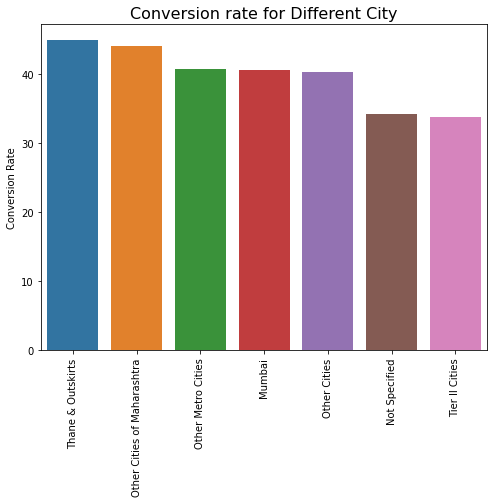

In [23]:
eda("City")

In [24]:
conversion_percent("City")

Thane & Outskirts              44.946809
Other Cities of Maharashtra    43.982495
Other Metro Cities             40.789474
Mumbai                         40.626940
Other Cities                   40.233236
Not Specified                  34.260016
Tier II Cities                 33.783784
Name: City, dtype: float64

#### The conversion rate for all of the cities is above 30%, however, conversion rate for Thane and Outsirts is  45 % while conversion rate for Tier 2 cities is less than 35%. 

### Specialization

In [25]:
df.Specialization.value_counts(dropna = False)

NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Media and Advertising                 203
Travel and Tourism                    203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

#### As the number of missing values are more than the mode, it wouldn't be appropriate to replace them with the mode and hence we'll replace the missing values with "Not Specified"

In [26]:
df.Specialization = df.Specialization.fillna("Not Specified")

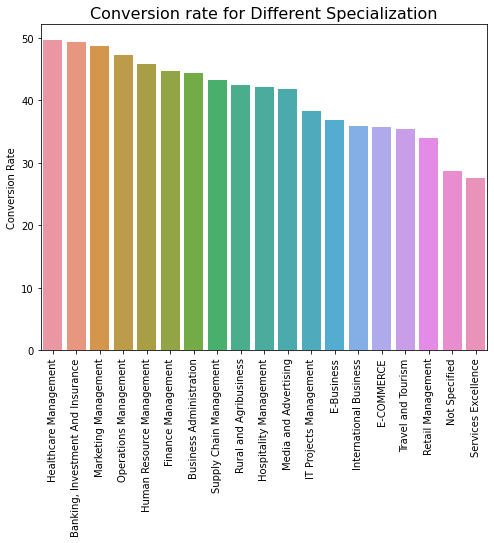

In [27]:
eda("Specialization")

In [28]:
conversion_percent("Specialization")

Healthcare Management                49.685535
Banking, Investment And Insurance    49.408284
Marketing Management                 48.687351
Operations Management                47.316103
Human Resource Management            45.754717
Finance Management                   44.672131
Business Administration              44.416873
Supply Chain Management              43.266476
Rural and Agribusiness               42.465753
Hospitality Management               42.105263
Media and Advertising                41.871921
IT Projects Management               38.251366
E-Business                           36.842105
International Business               35.955056
E-COMMERCE                           35.714286
Travel and Tourism                   35.467980
Retail Management                    34.000000
Not Specified                        28.668639
Services Excellence                  27.500000
Name: Specialization, dtype: float64

#### Here we see that there are 19 levels for the column specialization and we would need to create dummy variables for our logistic regression model, it would make our model very complex. We can see that all the Management specializations have nearly similar conversion rate, we will club these levels. We will also club E-Business and E-Commerce as they are similar specialization.

In [29]:
df['Specialization'] = df['Specialization'].apply(lambda x:'Management' if x.find('Management')>-1 else x)
df['Specialization'] = df['Specialization'].apply(lambda x:'E-Commerce' if x.find('E-')>-1 else x)

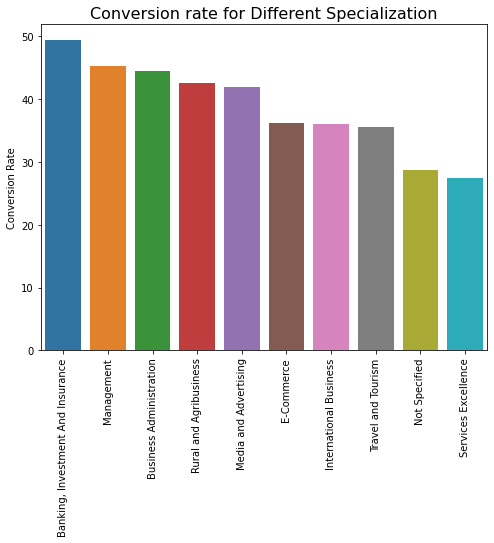

In [30]:
eda("Specialization")

#### As we see here, Banking and Management have a conversion rate of nearly 50% whereas Services Excellence has a conversion rate less than 30%.

### Tags

In [31]:
df.Tags.value_counts(dropna = False)

NaN                                                  3353
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with 

In [32]:
df.Tags = df.Tags.fillna("Not Specified")

In [33]:
Tags_Dummy = pd.get_dummies(df.Tags)
Tags_Dummy["Converted"] = df.Converted
Tags_Corr = Tags_Dummy.corr()["Converted"].sort_values(ascending = False)
Tags_Corr

Converted                                            1.000000
Will revert after reading the email                  0.644307
Closed by Horizzon                                   0.251229
Lost to EINS                                         0.168937
Busy                                                 0.052753
Interested in Next batch                             0.029384
Lateral student                                      0.022759
Shall take in the next coming month                  0.003465
Want to take admission but has financial problems   -0.002726
Recognition issue (DEC approval)                    -0.008238
In confusion whether part time or DLP               -0.008863
in touch with EINS                                  -0.010032
Still Thinking                                      -0.011456
University not recognized                           -0.011651
Lost to Others                                      -0.021804
opp hangup                                          -0.036225
number n

#### Here we see that there are 27 levels for the column Tags and we would need to create dummy variables for our logistic regression model, it would make our model very complex. We can see that multiple levels share similar relationship with conversions, we will club these levels.

In [34]:
df.Tags = df.Tags.apply(lambda x: "Other_Tags" if x in list(Tags_Corr[abs(Tags_Corr) < 0.15 ].index) else x)

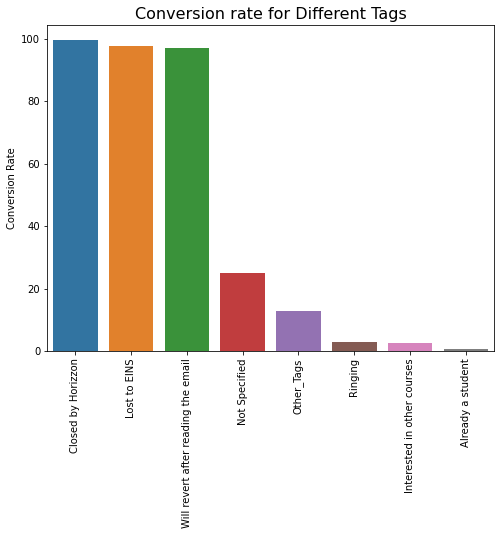

In [35]:
eda("Tags")

#### This looks very interesting. Three categories here have conversion rate more than 95% whereas other categories have a very low conversion. This seems like an important variable.

### Why did you choose the course?

In [36]:
df.Reason_choose_course.value_counts(dropna = False)

Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: Reason_choose_course, dtype: int64

#### As almost all the leads choose Better Career Prospects as the reason of choosing course, this variables looks of little importance and hence we'll drop the variable.

In [37]:
df.drop("Reason_choose_course", axis = 1, inplace = True)

### Current Occupation

In [38]:
df["Current occupation"].value_counts(dropna = False)

Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: Current occupation, dtype: int64

In [39]:
#Imputing null values with Unemplyoed
df['Current occupation'] = df['Current occupation'].replace(np.nan, 'Unemployed')

#### We are also going to group Housewife, Other and Businessman to one category as the number of leads for these categories are very low

In [40]:
df["Current occupation"] = df["Current occupation"].apply(lambda x: "Other_Occupation" if x in ["Housewife", "Other", "Businessman"] else x)

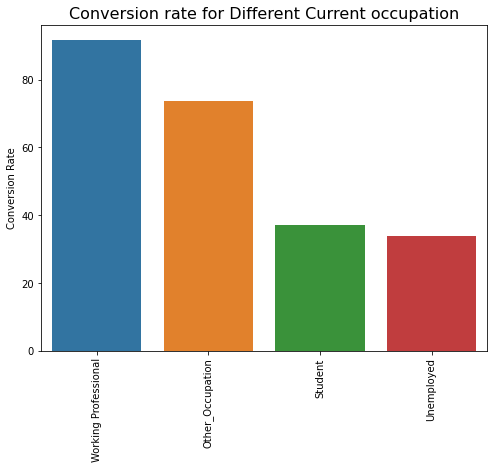

In [41]:
eda("Current occupation")

In [42]:
conversion_percent("Current occupation")

Working Professional    91.643059
Other_Occupation        73.529412
Student                 37.142857
Unemployed              33.908323
Name: Current occupation, dtype: float64

#### We see here that the conversion rate is as high as 91% where as it is as low as 33% for unemployed.

### Country

In [43]:
df.Country.value_counts(dropna = False)

India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Bangladesh                 2
Netherlands                2
China                      2
Uganda                     2
Philippines                2
Belgium                    2
Ghana                      2
Italy                      2
Asia/Pacific Region        2
Switzerland                1
Sri Lanka                  1
Indonesia                  1
Malaysia                   1
Liberia                    1
Russia        

#### We will group countries other than India as they are very less and it wont make sense to individually make their dummies.

In [44]:
df.Country = df.Country.apply(lambda x: "Other_Countries" if x not in ["India", np.nan] else x)

In [45]:
df.Country.value_counts()

India              6492
Other_Countries     287
Name: Country, dtype: int64

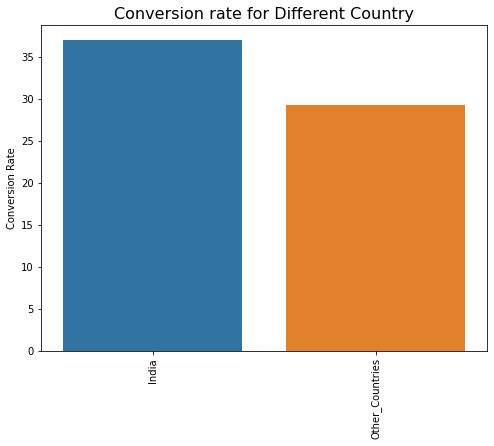

In [46]:
eda("Country")

In [47]:
conversion_percent("Country")

India              36.983980
Other_Countries    29.268293
Name: Country, dtype: float64

#### It seems like the country is India based and if we replace the null values with India, it will constitute of more than 95% of the data whichcould render the variable useless and hence we'll drop it.

In [48]:
df.drop("Country", axis = 1, inplace = True)

### Total Visits

In [49]:
df.TotalVisits.describe()

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

#### Here, total visits seems to have outlier as the maximum value of visits in 251 compared to 5 visits as 75th Quantile. Hence we are going to replace the null values with the median.

In [50]:
df.TotalVisits = df.TotalVisits.fillna(df.TotalVisits.median())

#### We will also treat the outliers here by capping the variable by the 95th percentile.

In [51]:
df.TotalVisits[df.TotalVisits > df.TotalVisits.quantile(0.95)] = df.TotalVisits.quantile(0.95)

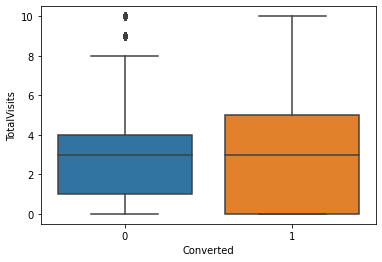

In [52]:
sns.boxplot(x = df.Converted, y = df.TotalVisits)
plt.show()

#### We can see from the boxplots that median for the converted and not-converted leads at almost the same but the 75th percentile is slightly greater for the converted leads.

### Page Views Per Page

In [53]:
df['Page Views Per Visit'].describe()

count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

#### The variable also seems to have outliers and hence we will replace the null values with median.

In [54]:
df["Page Views Per Visit"] = df["Page Views Per Visit"].fillna(df["Page Views Per Visit"].median())

In [55]:
# This variable also seems to have outliers and hence we'll treat them
df['Page Views Per Visit'].quantile([0.9, 0.95, 0.98, 0.99])

0.90    5.0
0.95    6.0
0.98    8.0
0.99    9.0
Name: Page Views Per Visit, dtype: float64

In [56]:
# Here we will cap the variable with 0.99 percentile.
df['Page Views Per Visit'][df['Page Views Per Visit'] > df['Page Views Per Visit'].quantile(0.99)] = df['Page Views Per Visit'].quantile(0.99)

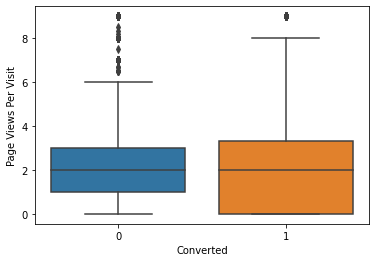

In [57]:
sns.boxplot(x = df.Converted, y = df['Page Views Per Visit'])
plt.show()

#### We can see from the boxplots that median for the converted and not-converted leads at almost the same but the 75th percentile is slightly greater for the converted leads.

### Last Activity

In [58]:
df["Last Activity"].value_counts(dropna = False)

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
NaN                              103
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64

#### We'll replace the null value and club other less frequency values in a level called "Others"

In [59]:
last_act = df["Last Activity"].value_counts()
df["Last Activity"] = df["Last Activity"].apply(lambda x: "Other_Activity" if x in last_act[last_act < 102].index else x)
df["Last Activity"] = df["Last Activity"].fillna("Other_Activity")

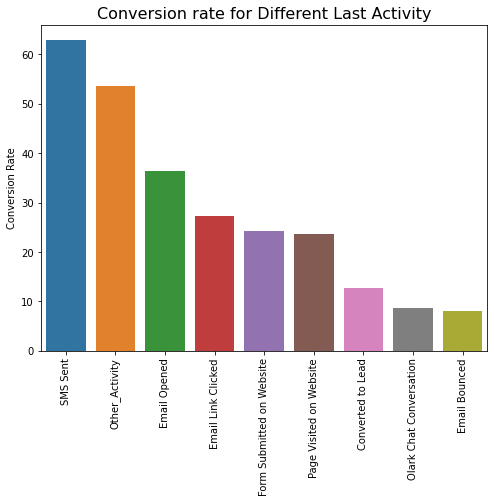

In [60]:
eda("Last Activity")

#### The conversion rate is maximum for leads with last Activity SMS sent and is significantly low for when a lead's email is bounced.

### Lead Source

In [61]:
df["Lead Source"].value_counts(dropna = False)

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Social Media            2
Live Chat               2
Press_Release           2
blog                    1
welearnblog_Home        1
WeLearn                 1
testone                 1
Pay per Click Ads       1
youtubechannel          1
NC_EDM                  1
Name: Lead Source, dtype: int64

#### Replacing all the less frequency values with Other_Source

In [62]:
source = df["Lead Source"].value_counts()
df["Lead Source"] = df["Lead Source"].apply(lambda x: "Other_Source" if x in source[source < 200].index else x)
df["Lead Source"] = df["Lead Source"].fillna("Other_Source")

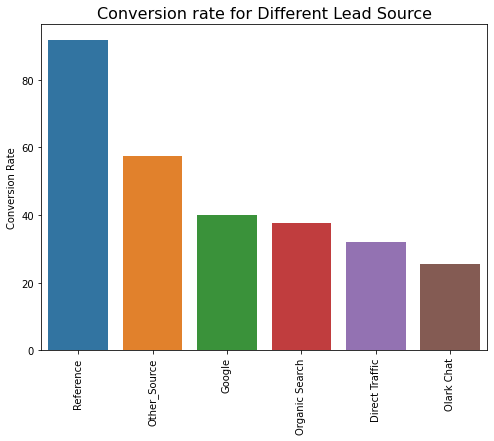

In [63]:
eda("Lead Source")

#### Conversion rate for people who come in through reference have a very high conversion rate and conversion rate for those who come through Olark Chat is very less.

### Email

In [64]:
df['Do Not Email'].value_counts()

No     8506
Yes     734
Name: Do Not Email, dtype: int64

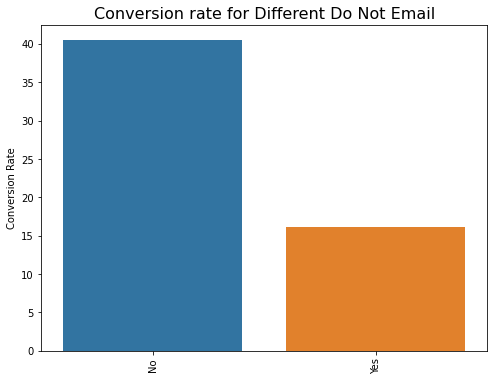

In [65]:
eda("Do Not Email")

#### Customers who didn't choose the option "Do Not Email" have high conversion rate.

### Call

In [66]:
df['Do Not Call'].value_counts()

No     9238
Yes       2
Name: Do Not Call, dtype: int64

#### As almost all the values for this column as No, we will drop this column.

In [67]:
df.drop('Do Not Call', axis = 1, inplace = True)

### Total Time Spent on Website

In [68]:
df["Total Time Spent on Website"].describe()

count    9240.000000
mean      487.698268
std       548.021466
min         0.000000
25%        12.000000
50%       248.000000
75%       936.000000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

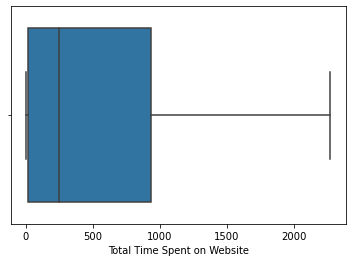

In [69]:
sns.boxplot(df['Total Time Spent on Website'])
plt.show()

#### As no outliers are visible in the boxplot, the variable doesn't require an outlier treatment.

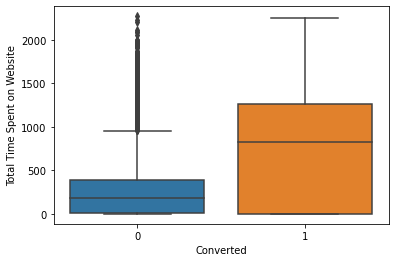

In [70]:
sns.boxplot(y = df['Total Time Spent on Website'], x = df.Converted)
plt.show()

#### Leads spending more time on the website are more likely to be converted.

### Last Notable Activity

In [71]:
df["Last Notable Activity"].value_counts()

Modified                        3407
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Form Submitted on Website          1
Email Received                     1
Resubscribed to emails             1
Approached upfront                 1
View in browser link Clicked       1
Name: Last Notable Activity, dtype: int64

#### This column is very similar to the last activity and hence we'll drop the column.

In [72]:
df.drop("Last Notable Activity", axis = 1, inplace = True)

### Mastering_Interview_Copy

In [73]:
df.Mastering_Interview_Copy.value_counts()

No     6352
Yes    2888
Name: Mastering_Interview_Copy, dtype: int64

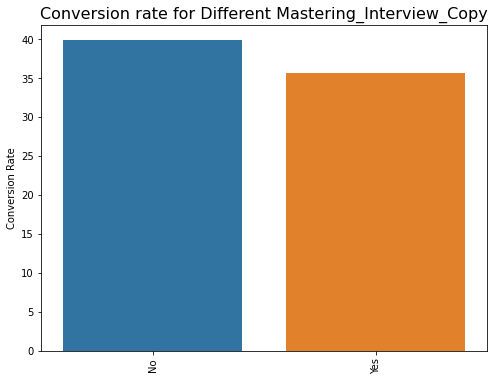

In [74]:
eda('Mastering_Interview_Copy')

#### Now, this is interesting, customers who didn't want a free copy of mastering the interview have a higher conversion rate which would have been expected to be other way round.

### Search

In [75]:
df.Search.value_counts()

No     9226
Yes      14
Name: Search, dtype: int64

#### Dropping the column as majority of the responses are No.

In [76]:
df.drop("Search", axis = 1, inplace = True)

### Newspaper Article

In [77]:
df['Newspaper Article'].value_counts()

No     9238
Yes       2
Name: Newspaper Article, dtype: int64

#### Dropping the column as majority of the responses are No.

In [78]:
df.drop("Newspaper Article", axis = 1, inplace = True)

### X Education Forums

In [79]:
df["X Education Forums"].value_counts()

No     9239
Yes       1
Name: X Education Forums, dtype: int64

#### Dropping the column as majority of the responses are No.

In [80]:
df.drop("X Education Forums", axis = 1, inplace = True)

### Newspaper

In [81]:
df['Newspaper'].value_counts()

No     9239
Yes       1
Name: Newspaper, dtype: int64

#### Dropping the column as majority of the responses are No.

In [82]:
df.drop("Newspaper", axis = 1, inplace = True)

### Digital Advertisement

In [83]:
df['Digital Advertisement'].value_counts()

No     9236
Yes       4
Name: Digital Advertisement, dtype: int64

#### Dropping the column as majority of the responses are No.

In [84]:
df.drop("Digital Advertisement", axis = 1, inplace = True)

### Through Recommendations

In [85]:
df['Through Recommendations'].value_counts()

No     9233
Yes       7
Name: Through Recommendations, dtype: int64

#### Dropping the column as majority of the responses are No.

In [86]:
df.drop("Through Recommendations", axis = 1, inplace = True)

### Lead Origin

In [87]:
df['Lead Origin'].value_counts()

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64

In [88]:
df = df[~(df['Lead Origin'] == 'Quick Add Form')]

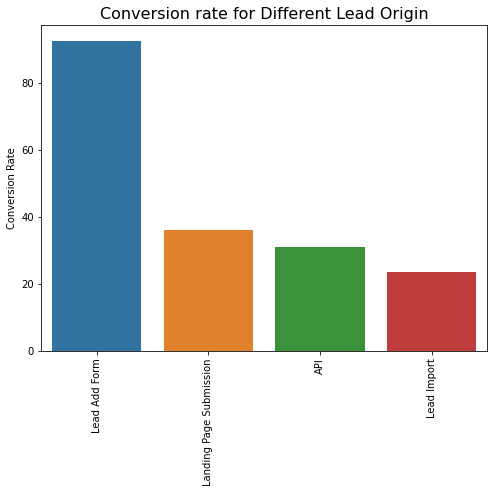

In [89]:
eda('Lead Origin')

#### The conversion rate for Lead Add form is maximum (as large as 90%) whereas it's pretty low for other lead origins.

### Correlation for numerical variables

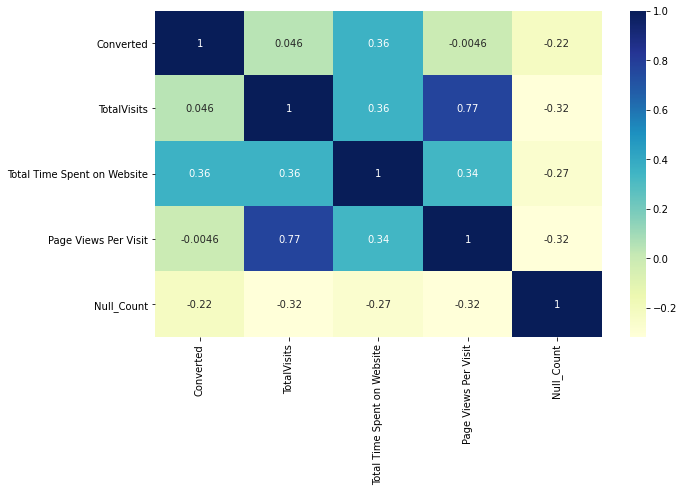

In [90]:
plt.figure(figsize = [10,6])
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

#### Total Visits and Page Views Per Visit are highly correlated and shall cause multicollinearity in our model.

In [91]:
df.isnull().sum()

Lead Origin                    0
Lead Source                    0
Do Not Email                   0
Converted                      0
TotalVisits                    0
Total Time Spent on Website    0
Page Views Per Visit           0
Last Activity                  0
Specialization                 0
Current occupation             0
Tags                           0
City                           0
Mastering_Interview_Copy       0
Null_Count                     0
dtype: int64

### Dummy Variable Creation

In [92]:
df["Converted"] = df["Converted"].astype("object")
categorical = df.select_dtypes("object").columns
categorical

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Converted',
       'Last Activity', 'Specialization', 'Current occupation', 'Tags', 'City',
       'Mastering_Interview_Copy'],
      dtype='object')

### Two of the variables have to be binary mapped here.

In [93]:
binary = ['Do Not Email', 'Mastering_Interview_Copy']
def binary_dummy(x):
    return x.map({'Yes': 1, "No": 0})
df[binary] = df[binary].apply(binary_dummy)

### For rest of the variables, we have to create the dummy variables manually.

In [94]:
dummy = pd.get_dummies(df['Lead Origin'], drop_first=True)
df = pd.concat([df, dummy], 1)
df.drop("Lead Origin",inplace=True, axis=1)

dummy = pd.get_dummies(df['Lead Source'])
dummy.drop('Other_Source', axis = 1, inplace = True)
df = pd.concat([df, dummy], 1)
df.drop("Lead Source",inplace=True, axis=1)

dummy = pd.get_dummies(df['Last Activity'])
dummy.drop('Other_Activity', axis = 1, inplace = True)
df = pd.concat([df, dummy], 1)
df.drop("Last Activity",inplace=True, axis=1)

dummy = pd.get_dummies(df['Specialization'])
dummy.drop('Not Specified', axis = 1, inplace = True)
df = pd.concat([df, dummy], 1)
df.drop("Specialization",inplace=True, axis=1)

dummy = pd.get_dummies(df['Current occupation'])
dummy.drop('Other_Occupation', axis = 1, inplace = True)
df = pd.concat([df, dummy], 1)
df.drop("Current occupation",inplace=True, axis=1)

dummy = pd.get_dummies(df['City'])
dummy.drop('Not Specified', axis = 1, inplace = True)
df = pd.concat([df, dummy], 1)
df.drop("City",inplace=True, axis=1)

dummy = pd.get_dummies(df['Tags'])
dummy.drop('Not Specified', axis = 1, inplace = True)
df = pd.concat([df, dummy], 1)
df.drop("Tags",inplace=True, axis=1)

In [95]:
# Checking the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9239 entries, 660737 to 579533
Data columns (total 48 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Do Not Email                         9239 non-null   int64  
 1   Converted                            9239 non-null   object 
 2   TotalVisits                          9239 non-null   float64
 3   Total Time Spent on Website          9239 non-null   int64  
 4   Page Views Per Visit                 9239 non-null   float64
 5   Mastering_Interview_Copy             9239 non-null   int64  
 6   Null_Count                           9239 non-null   int64  
 7   Landing Page Submission              9239 non-null   uint8  
 8   Lead Add Form                        9239 non-null   uint8  
 9   Lead Import                          9239 non-null   uint8  
 10  Direct Traffic                       9239 non-null   uint8  
 11  Google                 

## Splitting the Data into Training and Testing set.

In [96]:
# We specify this so that the train and test data set always have the same rows, respectively.
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features

In [97]:
# We will use minmax scaling.
Scaler = MinMaxScaler()

In [98]:
# Applying Scaler to all the columns except "0-1" and dummy variables.

scale_vars = [x for x in df.columns if (df[x].dtype=="int64") or (df[x].dtype=="float64")]

df_train[scale_vars] = Scaler.fit_transform(df_train[scale_vars])

df_train.head()

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Mastering_Interview_Copy,Null_Count,Landing Page Submission,Lead Add Form,Lead Import,Direct Traffic,Google,Olark Chat,Organic Search,Reference,Converted to Lead,Email Bounced,Email Link Clicked,Email Opened,Form Submitted on Website,Olark Chat Conversation,Page Visited on Website,SMS Sent,"Banking, Investment And Insurance",Business Administration,E-Commerce,International Business,Management,Media and Advertising,Rural and Agribusiness,Services Excellence,Travel and Tourism,Student,Unemployed,Working Professional,Mumbai,Other Cities,Other Cities of Maharashtra,Other Metro Cities,Thane & Outskirts,Tier II Cities,Already a student,Closed by Horizzon,Interested in other courses,Lost to EINS,Other_Tags,Ringing,Will revert after reading the email
Lead Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
608309,0.0,0,0.3,0.620599,0.333333,0.0,0.642857,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
601302,0.0,0,1.0,0.719190,0.555556,0.0,0.071429,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
597540,1.0,0,0.6,0.060299,0.666667,0.0,0.428571,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
591462,0.0,1,0.2,0.479754,0.111111,0.0,0.571429,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
589061,0.0,0,0.2,0.583627,0.222222,1.0,0.214286,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0


### Checking the Conversion Rate.

In [99]:
conversion_rate = (sum(df_train['Converted'])/len(df_train['Converted'].index))*100
conversion_rate 

38.920674192051955

<Figure size 720x720 with 0 Axes>

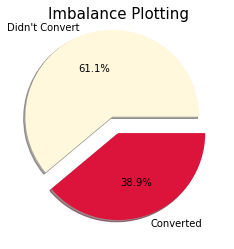

In [100]:
Imbalance = df_train.Converted.value_counts().reset_index()

plt.figure(figsize=(10,10))
x= ['Non-Defaulter','Defaulter']
Imbalance.plot.pie(autopct='%1.1f%%', y="Converted",
                   labels=["Didn't Convert","Converted"], shadow=True,
                   explode=(0.2,0), legend=False, colors=["#FFF8DC","#DC143C"])
plt.ylabel("")
plt.title("Imbalance Plotting", fontsize=15)
plt.show()

In [194]:
imbalance_ratio = df[df.Converted == 0].shape[0]/df[df.Converted == 1].shape[0]
imbalance_ratio

1.5952247191011235

The data seems appropriate as the imbalance ratio isn't much.

### Dividing into X and Y sets for Model Building.

In [101]:
y_train = df_train.pop("Converted")
x_train = df_train

In [102]:
x_train.shape

(6467, 47)

In [103]:
y_train.shape

(6467,)

### Building our Model.

In [104]:
# Logistic regression model
x_train = x_train.astype("float")
y_train = y_train.astype("float")
logm = sm.GLM(y_train,(sm.add_constant(x_train)), family = sm.families.Binomial())
logm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6419
Model Family:                Binomial   Df Model:                           47
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1335.0
Date:                Sun, 07 Mar 2021   Deviance:                       2670.0
Time:                        00:36:17   Pearson chi2:                 1.10e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -1.1810      1.093     -1.080      0.280      -3.324       0.962
Do Not Email                           -0.8503      0.263     -3.237      0.001      -1.365      -0.335
TotalVisits                             1.0584      0.306      3.456      0.001       0.458       1.659
Total Time Spent on Website             4.3600      0.244     17.869      0.000       3.882       4.838
Page Views Per Visit                   -1.2670      0.406     -3.124      0.002      -2.062      -0.472
Mastering_Interview_Copy               -0.1183      0.166     -0.711      0.477      -0.444       0.208
Null_Count                             -2.0690      0.339     -6.108      0.000      -2.733      -1.405
Landing Page Submission                -0.4240      0.241     -1.757      0.079      -0.897       0.049
Lead Add Form                           4.3222      0.563      7.682      0.000       3.219       5.425
Lead Import                            -0.2734      0.897     -0.305      0.760      -2.031       1.484
Direct Traffic                          0.1680      0.400      0.420      0.675      -0.616       0.952
Google                                  0.1481      0.381      0.389      0.698      -0.599       0.895
Olark Chat                              1.0925      0.409      2.673      0.008       0.291       1.894
Organic Search                          0.0706      0.397      0.178      0.859      -0.707       0.849
Reference                              -3.3818      0.586     -5.773      0.000      -4.530      -2.234
Converted to Lead                      -1.8378      0.523     -3.514      0.000      -2.863      -0.813
Email Bounced                          -1.5432      0.585     -2.638      0.008      -2.690      -0.397
Email Link Clicked                     -1.1387      0.492     -2.314      0.021      -2.103      -0.174
Email Opened                           -0.3124      0.364     -0.859      0.391      -1.026       0.401
Form Submitted on Website              -1.0674      0.651     -1.638      0.101      -2.344       0.209
Olark Chat Conversation                -1.8585      0.421     -4.418      0.000      -2.683      -1.034
Page Visited on Website                -0.8071      0.411     -1.964      0.050      -1.613      -0.002
SMS Sent                                1.5133      0.360      4.198      0.000       0.807       2.220
Banking, Investment And Insurance       0.3308      0.397      0.833      0.405      -0.448       1.109
Business Administration                 0.1211      0.369      0.328      0.743      -0.603       0.845
E-Commerce                              0.2919      0.495      0.590      0.555      -0.677       1.261
International Business                  0.3995      0.478      0.83

#### As the number of features are 47, we will use RFE to select top 20 features for our model.

### Feature Selection Using RFE

In [105]:
logreg = LogisticRegression()

In [106]:
# Running RFE with 15 variables as output
rfe = RFE(logreg, 20)
rfe = rfe.fit(x_train, y_train)

In [107]:
# Features that have been selected by RFE
list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', True, 1),
 ('TotalVisits', False, 3),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 2),
 ('Mastering_Interview_Copy', False, 24),
 ('Null_Count', True, 1),
 ('Landing Page Submission', True, 1),
 ('Lead Add Form', True, 1),
 ('Lead Import', True, 1),
 ('Direct Traffic', False, 21),
 ('Google', False, 22),
 ('Olark Chat', True, 1),
 ('Organic Search', False, 20),
 ('Reference', True, 1),
 ('Converted to Lead', True, 1),
 ('Email Bounced', True, 1),
 ('Email Link Clicked', False, 4),
 ('Email Opened', False, 25),
 ('Form Submitted on Website', False, 5),
 ('Olark Chat Conversation', True, 1),
 ('Page Visited on Website', False, 7),
 ('SMS Sent', True, 1),
 ('Banking, Investment And Insurance', False, 17),
 ('Business Administration', False, 28),
 ('E-Commerce', False, 23),
 ('International Business', False, 16),
 ('Management', False, 18),
 ('Media and Advertising', False, 19),
 ('Rural and Agribusiness', False, 15),
 ('Services Excellence'

In [108]:
# Storing the columns selected by RFE in the variable 'RFE_cols'
RFE_cols = x_train.columns[rfe.support_]

In [109]:
# Checking the columns which were not selected using RFE
x_train.columns[~rfe.support_]

Index(['TotalVisits', 'Page Views Per Visit', 'Mastering_Interview_Copy',
       'Direct Traffic', 'Google', 'Organic Search', 'Email Link Clicked',
       'Email Opened', 'Form Submitted on Website', 'Page Visited on Website',
       'Banking, Investment And Insurance', 'Business Administration',
       'E-Commerce', 'International Business', 'Management',
       'Media and Advertising', 'Rural and Agribusiness',
       'Services Excellence', 'Travel and Tourism', 'Student', 'Unemployed',
       'Mumbai', 'Other Cities', 'Other Cities of Maharashtra',
       'Other Metro Cities', 'Thane & Outskirts', 'Tier II Cities'],
      dtype='object')

### Model 1 : Using 20 variables given by RFE

In [127]:
# Creating x_train dataframe using RFE selected variables
x_train_rfe = x_train[RFE_cols]

In [128]:
x_train_rfe = sm.add_constant(x_train_rfe)
logm1 = sm.GLM(y_train, x_train_rfe, family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6446
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1356.2
Date:                Sun, 07 Mar 2021   Deviance:                       2712.4
Time:                        00:43:20   Pearson chi2:                 1.05e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -1.2336      0.236     -5.235      0.000      -1.696      -0.772
Do Not Email                           -0.9276      0.250     -3.712      0.000      -1.417      -0.438
Total Time Spent on Website             4.2924      0.238     18.071      0.000       3.827       4.758
Null_Count                             -1.9010      0.313     -6.080      0.000      -2.514      -1.288
Landing Page Submission                -0.8951      0.134     -6.699      0.000      -1.157      -0.633
Lead Add Form                           4.1544      0.422      9.849      0.000       3.328       4.981
Lead Import                            -0.9645      0.760     -1.269      0.204      -2.454       0.525
Olark Chat                              0.8970      0.166      5.396      0.000       0.571       1.223
Reference                              -3.3881      0.570     -5.949      0.000      -4.504      -2.272
Converted to Lead                      -1.3958      0.379     -3.682      0.000      -2.139      -0.653
Email Bounced                          -0.9919      0.494     -2.010      0.044      -1.959      -0.025
Olark Chat Conversation                -1.4151      0.233     -6.068      0.000      -1.872      -0.958
SMS Sent                                1.8947      0.112     16.990      0.000       1.676       2.113
Working Professional                    0.7947      0.367      2.168      0.030       0.076       1.513
Already a student                      -4.4932      1.020     -4.407      0.000      -6.492      -2.495
Closed by Horizzon                     26.1612   1.21e+04      0.002      0.998   -2.37e+04    2.38e+04
Interested in other courses            -2.7412      0.369     -7.424      0.000      -3.465      -2.018
Lost to EINS                            5.5243      0.737      7.498      0.000       4.080       6.968
Other_Tags                             -1.3815      0.168     -8.203      0.000      -1.712      -1.051
Ringing                                -3.5239      0.249    -14.127      0.000      -4.013      -3.035
Will revert after reading the email     3.9829      0.218     18.277      0.000       3.556       4.410
=======================================================================================================
"""

#### VIF (Model 1)

In [129]:
x_train_rfe.drop("const", axis = 1, inplace = True)

In [130]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Lead Add Form,4.71
7,Reference,4.42
2,Null_Count,3.48
3,Landing Page Submission,2.88
6,Olark Chat,2.37
1,Total Time Spent on Website,2.33
19,Will revert after reading the email,2.27
0,Do Not Email,1.86
9,Email Bounced,1.78
11,SMS Sent,1.75


### Model 2 : Dropping `Closed by horizzon` from Model 1
because of it's high p-value, it is insignificant

In [131]:
# Creating x_train_new1 dataframe for model 2.
x_train_new1 = x_train_rfe.drop(["Closed by Horizzon"], axis=1)

In [132]:
# Adding a constant variable
x_train_new1 = sm.add_constant(x_train_new1)

In [133]:
# Running the Logistic regression on model2
logm2 = sm.GLM(y_train, x_train_new1, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6447
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1475.4
Date:                Sun, 07 Mar 2021   Deviance:                       2950.7
Time:                        00:43:26   Pearson chi2:                 2.01e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.2581      0.209     -1.233      0.218      -0.668       0.152
Do Not Email                           -0.9838      0.246     -4.007      0.000      -1.465      -0.503
Total Time Spent on Website             4.3126      0.228     18.953      0.000       3.867       4.759
Null_Count                             -3.1492      0.284    -11.085      0.000      -3.706      -2.592
Landing Page Submission                -0.8577      0.129     -6.650      0.000      -1.110      -0.605
Lead Add Form                           4.2235      0.419     10.081      0.000       3.402       5.045
Lead Import                            -1.0325      0.748     -1.380      0.168      -2.499       0.434
Olark Chat                              0.9602      0.162      5.932      0.000       0.643       1.278
Reference                              -1.1816      0.482     -2.450      0.014      -2.127      -0.236
Converted to Lead                      -1.5080      0.366     -4.120      0.000      -2.225      -0.791
Email Bounced                          -0.8868      0.451     -1.968      0.049      -1.770      -0.003
Olark Chat Conversation                -1.4076      0.216     -6.520      0.000      -1.831      -0.985
SMS Sent                                1.7127      0.109     15.779      0.000       1.500       1.925
Working Professional                    1.5412      0.316      4.884      0.000       0.923       2.160
Already a student                      -5.1777      1.022     -5.067      0.000      -7.181      -3.175
Interested in other courses            -3.6000      0.374     -9.621      0.000      -4.333      -2.867
Lost to EINS                            4.9980      0.735      6.801      0.000       3.558       6.438
Other_Tags                             -2.0133      0.162    -12.453      0.000      -2.330      -1.696
Ringing                                -4.1944      0.249    -16.854      0.000      -4.682      -3.707
Will revert after reading the email     3.1370      0.196     16.032      0.000       2.754       3.521
=======================================================================================================
"""

#### VIF (Model 2)

In [134]:
x_train_new1.drop("const",inplace=True,axis=1)

In [135]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = x_train_new1.columns
vif['VIF'] = [variance_inflation_factor(x_train_new1.values, i) for i in range(x_train_new1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Lead Add Form,4.59
7,Reference,4.32
2,Null_Count,3.44
3,Landing Page Submission,2.80
6,Olark Chat,2.32
1,Total Time Spent on Website,2.17
18,Will revert after reading the email,2.03
0,Do Not Email,1.86
9,Email Bounced,1.78
11,SMS Sent,1.74


### Model 3 : Dropping `Lead Import` from model 2
because it has high p-value.

In [136]:
# Creating x_train_new2 dataframe for model 3.
x_train_new2 = x_train_new1.drop(["Lead Import"], axis=1)

# Adding a constant variable
x_train_new2 = sm.add_constant(x_train_new2)

# Running the Logistic regression on model2
logm3 = sm.GLM(y_train, x_train_new2, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6448
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1476.4
Date:                Sun, 07 Mar 2021   Deviance:                       2952.8
Time:                        00:44:32   Pearson chi2:                 2.00e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.2913      0.208     -1.401      0.161      -0.699       0.116
Do Not Email                           -0.9794      0.245     -3.989      0.000      -1.461      -0.498
Total Time Spent on Website             4.3336      0.227     19.069      0.000       3.888       4.779
Null_Count                             -3.1389      0.284    -11.060      0.000      -3.695      -2.583
Landing Page Submission                -0.8344      0.128     -6.521      0.000      -1.085      -0.584
Lead Add Form                           4.2499      0.419     10.153      0.000       3.430       5.070
Olark Chat                              0.9865      0.161      6.128      0.000       0.671       1.302
Reference                              -1.1817      0.482     -2.450      0.014      -2.127      -0.236
Converted to Lead                      -1.5020      0.366     -4.103      0.000      -2.219      -0.784
Email Bounced                          -0.8910      0.451     -1.977      0.048      -1.774      -0.008
Olark Chat Conversation                -1.4034      0.216     -6.504      0.000      -1.826      -0.981
SMS Sent                                1.7063      0.108     15.753      0.000       1.494       1.919
Working Professional                    1.5396      0.316      4.877      0.000       0.921       2.158
Already a student                      -5.1770      1.022     -5.065      0.000      -7.180      -3.174
Interested in other courses            -3.5912      0.374     -9.601      0.000      -4.324      -2.858
Lost to EINS                            4.9985      0.735      6.802      0.000       3.558       6.439
Other_Tags                             -2.0075      0.162    -12.429      0.000      -2.324      -1.691
Ringing                                -4.1901      0.249    -16.847      0.000      -4.678      -3.703
Will revert after reading the email     3.1375      0.196     16.039      0.000       2.754       3.521
=======================================================================================================
"""

#### VIF (Model 3)

In [137]:
x_train_new2.drop("const",inplace=True,axis=1)

In [138]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = x_train_new2.columns
vif['VIF'] = [variance_inflation_factor(x_train_new2.values, i) for i in range(x_train_new2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Lead Add Form,4.59
6,Reference,4.32
2,Null_Count,3.40
3,Landing Page Submission,2.77
5,Olark Chat,2.31
1,Total Time Spent on Website,2.17
17,Will revert after reading the email,2.02
0,Do Not Email,1.86
8,Email Bounced,1.78
10,SMS Sent,1.74


#### This model looks good, as there seems to be VERY LOW Multicollinearity between the predictors and the p-values for all the predictors seems to be significant. Now, we will check various metrics to see how good our model is.

In [139]:
# Getting the predicted values on the train set
x_train_new2 = sm.add_constant(x_train_new2)
y_train_pred = res.predict(x_train_new2)
y_train_pred[:10]

Lead Number
608309    0.388386
601302    0.038130
597540    0.001135
591462    0.498530
589061    0.030497
628456    0.001503
588058    0.999794
649586    0.115843
592599    0.120678
649186    0.926527
dtype: float64

In [140]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.38838608, 0.03813   , 0.00113475, 0.49852972, 0.03049673,
       0.00150288, 0.99979407, 0.11584304, 0.12067846, 0.92652729])

In [141]:
# Creating a dataframe with conversion probability and conversion flag.
y_train_pred_final = pd.DataFrame({"Converted":y_train.astype("int64").values, "Conversion_Prob":y_train_pred})
y_train_pred_final.head()

,Converted,Conversion_Prob
0,0,0.388386
1,0,0.038130
2,0,0.001135
3,1,0.498530
4,0,0.030497


#### Creating a new column 'predicted' with 1 if Conversion_Prob > 0.5 else 0

In [142]:
y_train_pred_final["predicted"] = y_train_pred_final["Conversion_Prob"].apply(lambda x : 1 if x>0.5 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,predicted
0,0,0.388386,0
1,0,0.038130,0
2,0,0.001135,0
3,1,0.498530,0
4,0,0.030497,0


### Confusion matrix 

In [143]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3750  200]
 [ 368 2149]]


In [144]:
# Predicted     not_converted    converted
# Actual
# not_converted        3725           225
# converted            409            2108

In [145]:
# Let's check the overall accuracy.
# Accuracy = Proportion of total number of predictions that were correct.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9121694758002165


In [146]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [147]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8537941994437823

In [148]:
# Let us calculate specificity
TN / float(TN+FP)

0.9493670886075949

In [149]:
# Calculate false postive rate - predicting converted when customer haven't converted
print(FP/ float(TN+FP))

0.05063291139240506


In [150]:
# positive predictive value 
print (TP / float(TP+FP))

0.9148573861217539


In [151]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9106362311801846


### Plotting the ROC Curve
An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [152]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [153]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )

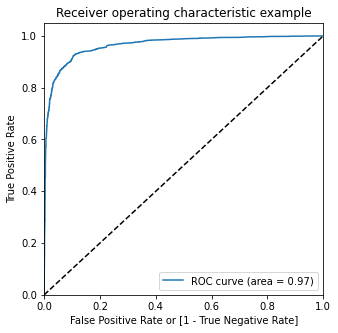

In [154]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

### Finding Optimal Cutoff Point

#### Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [155]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.388386,0,1,1,1,1,0,0,0,0,0,0
1,0,0.038130,0,1,0,0,0,0,0,0,0,0,0
2,0,0.001135,0,1,0,0,0,0,0,0,0,0,0
3,1,0.498530,0,1,1,1,1,1,0,0,0,0,0
4,0,0.030497,0,1,0,0,0,0,0,0,0,0,0


In [156]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.389207  1.000000  0.000000
0.1   0.1  0.816453  0.970997  0.717975
0.2   0.2  0.871965  0.944776  0.825570
0.3   0.3  0.904902  0.912197  0.900253
0.4   0.4  0.910623  0.882002  0.928861
0.5   0.5  0.912169  0.853794  0.949367
0.6   0.6  0.910159  0.822408  0.966076
0.7   0.7  0.897789  0.777513  0.974430
0.8   0.8  0.884954  0.733810  0.981266
0.9   0.9  0.862378  0.662694  0.989620


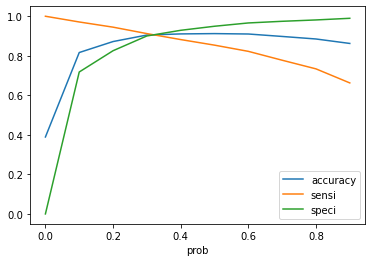

In [157]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [158]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.388386,0,1,1,1,1,0,0,0,0,0,0,1
1,0,0.038130,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.001135,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0.498530,0,1,1,1,1,1,0,0,0,0,0,1
4,0,0.030497,0,1,0,0,0,0,0,0,0,0,0,0


In [159]:
train_y = pd.DataFrame(y_train).reset_index()
train_y["Conversion_Prob"] = y_train_pred_final.Conversion_Prob
train_y["final_predicted"] = y_train_pred_final.final_predicted
train_y.head()

,Lead Number,Converted,Conversion_Prob,final_predicted
0,608309,0.0,0.388386,1
1,601302,0.0,0.038130,0
2,597540,0.0,0.001135,0
3,591462,1.0,0.498530,1
4,589061,0.0,0.030497,0


In [160]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9049018091850936

In [161]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3556,  394],
       [ 221, 2296]], dtype=int64)

In [162]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [163]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.912197059992054

In [164]:
# Let us calculate specificity
TN / float(TN+FP)

0.900253164556962

In [165]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.09974683544303797


In [166]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8535315985130112


In [167]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9414879534021711


#### All the metrics look pretty great and it seems like a good model. Let's check how it behaves with the test dataset.

### Making predictions on the test set

In [168]:
# Scaling Numerical Variables in Testing Dataset.
df_test[scale_vars] = Scaler.transform(df_test[scale_vars])

In [169]:
# Spliting testing Data into x_test and y_test
y_test = df_test.pop('Converted')
x_test = df_test

In [171]:
# Creating x_test_m3 dataframe by using the column names of x_train_new2 dataframe used for bulding model 3.
x_test_m3 = sm.add_constant(x_test)
x_test_m3 = x_test_m3[list(x_train_new2.columns)]

In [172]:
# Making Predictions on the testing dataset.
y_test_pred = res.predict(x_test_m3)

In [174]:
#Cheking the predicted probabilities
y_test_pred[:10]

Lead Number
653848    0.166373
603210    0.293471
641366    0.168004
653757    0.627809
601110    0.007587
601844    0.061451
623622    0.198364
639710    0.996119
602676    0.000462
595906    0.210377
dtype: float64

In [176]:
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.reset_index(inplace = True)
y_pred_1.columns = ['Lead Number', 'Conversion_Prob']

In [177]:
#Getting the final predicted flag for conversion on test data
y_pred_1["final_predicted"] = y_pred_1.Conversion_Prob.apply(lambda x: 1 if x>0.3 else 0)

In [179]:
y_test = pd.DataFrame(y_test)
y_pred_1['Converted'] = list(y_test.Converted)
y_pred_1.head()

### Checking the accuracy and other metrics for the model.

In [181]:
metrics.accuracy_score(y_pred_1.Converted,y_pred_1.final_predicted)

0.9011544011544012

In [182]:
confusion = metrics.confusion_matrix(y_pred_1.Converted, y_pred_1.final_predicted)
confusion

array([[1553,  176],
       [  98,  945]], dtype=int64)

In [183]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [184]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9060402684563759

In [185]:
# Let us calculate specificity
TN / float(TN+FP)

0.898207056101793

In [186]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.10179294389820706


In [187]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8429973238180196


In [188]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9406420351302242


### Calculating Lead Score for each of the Leads.

In [189]:
lead_score = pd.concat([train_y, y_pred_1], axis = 0)
lead_score.head()

,Lead Number,Converted,Conversion_Prob,final_predicted
0,608309,0.0,0.388386,1
1,601302,0.0,0.038130,0
2,597540,0.0,0.001135,0
3,591462,1.0,0.498530,1
4,589061,0.0,0.030497,0


In [190]:
lead_score["Lead Score"] = lead_score.Conversion_Prob.apply(lambda x: x*100)

In [197]:
lead_score[['Lead Number', 'Lead Score']].head(10)

,Lead Number,Lead Score
0,608309,38.838608
1,601302,3.813000
2,597540,0.113475
3,591462,49.852972
4,589061,3.049673
5,628456,0.150288
6,588058,99.979407
7,649586,11.584304
8,592599,12.067846
9,649186,92.652729


In [198]:
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6467
Model:                            GLM   Df Residuals:                     6448
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1476.4
Date:                Sun, 07 Mar 2021   Deviance:                       2952.8
Time:                        01:11:24   Pearson chi2:                 2.00e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

# CONCLUSION

#### Metrics for Train Data: - 
Accuracy: 0.905
Sensitivity: 0.912
Specificity: 0.900

#### Metrics for Test Data: -
Accuracy: 0.901
Sensitivity: 0.906
Specificity: 0.898

#### The model accuracy, sensitivity and specificity, both for train and test data, are coming out to be nearly 90% which shows that the model is a good fit.


#### Variables that are influencing the conversion rate positively - 

   - Total Time Spent on Website: The more time a lead spends on the website, the more is the chance of conversion.
   - Lead Add Form: Conversion rate is high when the lead origin is Lead Add Form.
   - SMS Sent: Conversion rate is high when the last activity is sending SMS.
   - Working Professional: Lead is most likely to be converted if he/she is a working professional.
   - Conversion rate is high when Tag = Lost to EINS
   - Conversion rate is high when the lead has recieved the email and will likely revert back.
   
#### Variables that are influencing the conversion rate negatively - 

   - An important variable is Null Count, i.e. the amount of infomation a lead is revealing is important to note as the missing information leads to less conversion rate.
   - The conversion rate is negatively influenced if the lead source is Reference.
   - Already a student - If the lead is a students, he/she is less likely to be converted. It seems like the courses are designed for working professionals.
   - If the lead is interested in other courses, he is less likely to be converted.
   - Ringing: If the leads isn't answering and ignoring `(RUDE)` the calls, they are less likely to be converted.  


